In [3]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, arch_scan, get_data, get_data_softDrop
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quark jets, R = 0.8

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=True,efrac=False,base=base,nmax=nmax)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('q',hlevel=False,efrac=False,base=base,nmax=nmax)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

In [ ]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
#out_act = keras.activations.linear
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":5,
                "optimizer":Adam(1e-3),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":100,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save("keras_models_v2/qjet_EFN_zpT_iter1.keras")
del efn
gc.collect()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation_35 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_35[0][0]']          
                                                                                            

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 165ms/step - loss: 0.6931 - acc: 0.5190 - val_loss: 0.6931 - val_acc: 0.5274
Epoch 2/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6931 - acc: 0.5154 - val_loss: 0.6931 - val_acc: 0.5157
Epoch 3/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6931 - acc: 0.5171 - val_loss: 0.6931 - val_acc: 0.5103
Epoch 4/150
20/20 [==============================] - 3s 129ms/step - loss: 0.6931 - acc: 0.5103 - val_loss: 0.6931 - val_acc: 0.5137
Epoch 5/150
20/20 [==============================] - 3s 146ms/step - loss: 0.6931 - acc: 0.5097 - val_loss: 0.6931 - val_acc: 0.5084
Epoch 6/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5104 - val_loss: 0.6931 - val_acc: 0.5207
Epoch 7/150
20/20 [==============================] - 3s 153ms/step - loss: 0.6931 - acc: 0.5119 - val_loss: 0.6930 - val_acc: 0.5073
Epoch 8/150
20/20 [==============================] - 3s 143ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 176ms/step - loss: 0.6931 - acc: 0.5253 - val_loss: 0.6931 - val_acc: 0.5345
Epoch 2/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6931 - acc: 0.5276 - val_loss: 0.6931 - val_acc: 0.5188
Epoch 3/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6931 - acc: 0.5208 - val_loss: 0.6931 - val_acc: 0.5131
Epoch 4/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6931 - acc: 0.5186 - val_loss: 0.6931 - val_acc: 0.5105
Epoch 5/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6931 - acc: 0.5103 - val_loss: 0.6931 - val_acc: 0.5109
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6931 - acc: 0.5107 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 7/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6930 - acc: 0.5097 - val_loss: 0.6930 - val_acc: 0.5112
Epoch 8/150
20/20 [==============================] - 3s 143ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 167ms/step - loss: 0.6931 - acc: 0.5161 - val_loss: 0.6931 - val_acc: 0.5348
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5280 - val_loss: 0.6931 - val_acc: 0.5158
Epoch 3/150
20/20 [==============================] - 3s 146ms/step - loss: 0.6931 - acc: 0.5150 - val_loss: 0.6931 - val_acc: 0.5072
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6931 - acc: 0.5177 - val_loss: 0.6931 - val_acc: 0.5120
Epoch 5/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6931 - acc: 0.5110 - val_loss: 0.6930 - val_acc: 0.5083
Epoch 6/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5115 - val_loss: 0.6930 - val_acc: 0.5072
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5137 - val_loss: 0.6930 - val_acc: 0.5068
Epoch 8/150
20/20 [==============================] - 3s 134ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 173ms/step - loss: 0.6931 - acc: 0.5039 - val_loss: 0.6931 - val_acc: 0.5111
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6931 - acc: 0.5226 - val_loss: 0.6931 - val_acc: 0.5347
Epoch 3/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6931 - acc: 0.5276 - val_loss: 0.6931 - val_acc: 0.5244
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6931 - acc: 0.5188 - val_loss: 0.6931 - val_acc: 0.5297
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6931 - acc: 0.5197 - val_loss: 0.6930 - val_acc: 0.5144
Epoch 6/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6930 - acc: 0.5185 - val_loss: 0.6930 - val_acc: 0.5099
Epoch 7/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6930 - acc: 0.5120 - val_loss: 0.6930 - val_acc: 0.5167
Epoch 8/150
20/20 [==============================] - 3s 141ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 169ms/step - loss: 0.6931 - acc: 0.5121 - val_loss: 0.6931 - val_acc: 0.5355
Epoch 2/150
20/20 [==============================] - 3s 146ms/step - loss: 0.6931 - acc: 0.5276 - val_loss: 0.6931 - val_acc: 0.5285
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5265 - val_loss: 0.6931 - val_acc: 0.5136
Epoch 4/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6931 - acc: 0.5146 - val_loss: 0.6931 - val_acc: 0.5221
Epoch 5/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6931 - acc: 0.5196 - val_loss: 0.6931 - val_acc: 0.5158
Epoch 6/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6930 - acc: 0.5163 - val_loss: 0.6930 - val_acc: 0.5165
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5156 - val_loss: 0.6930 - val_acc: 0.5126
Epoch 8/150
20/20 [==============================] - 3s 142ms/step - 

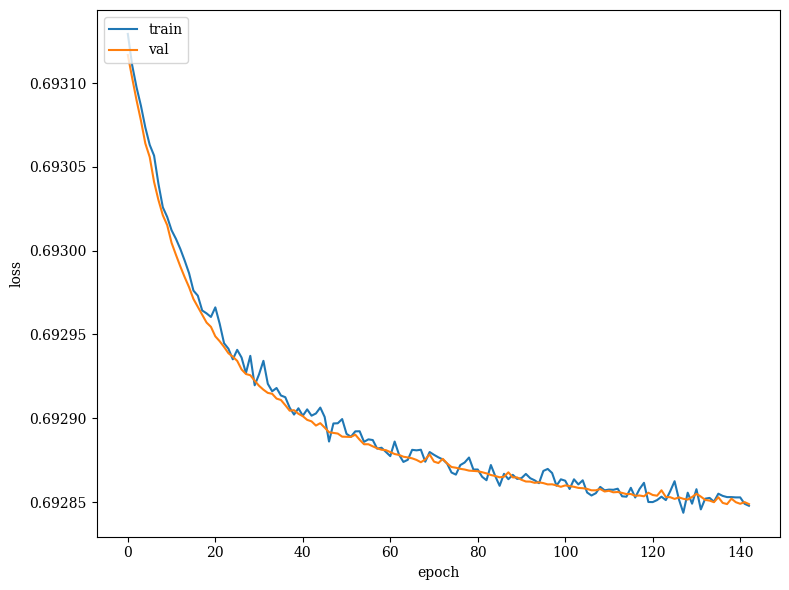

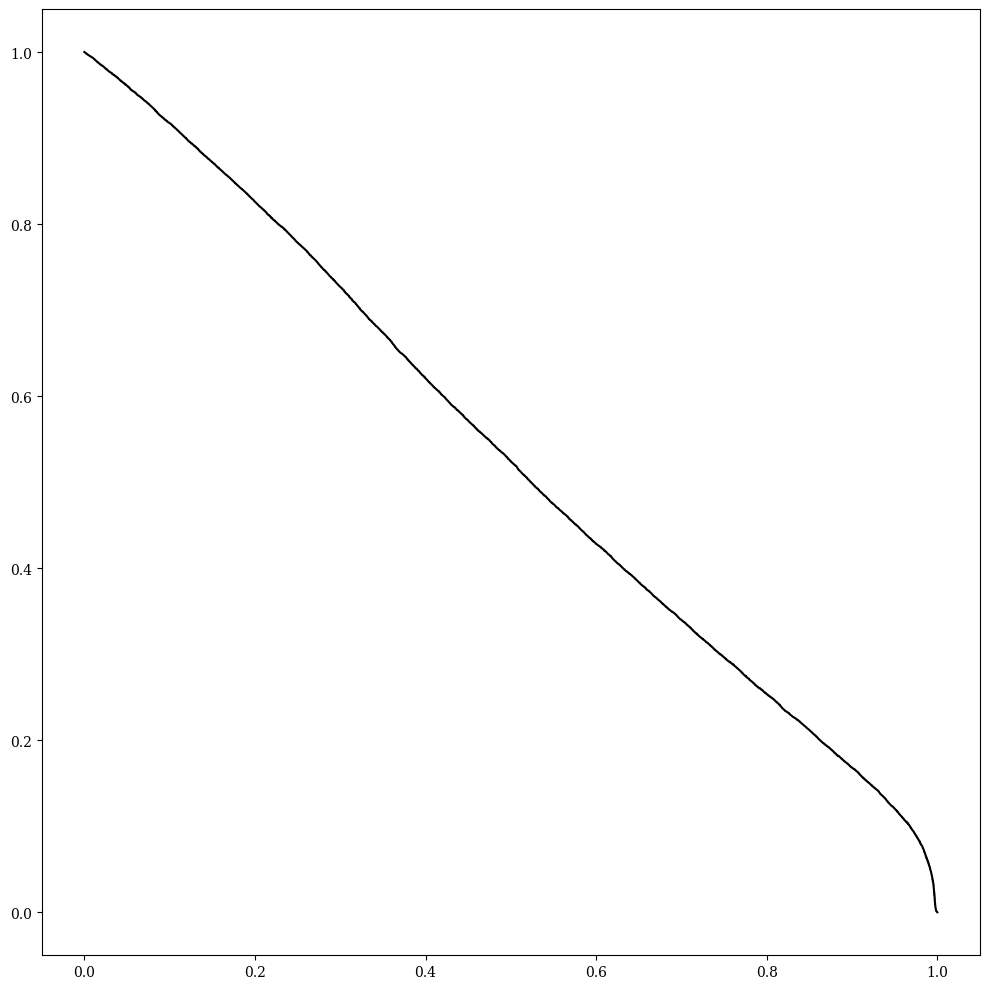

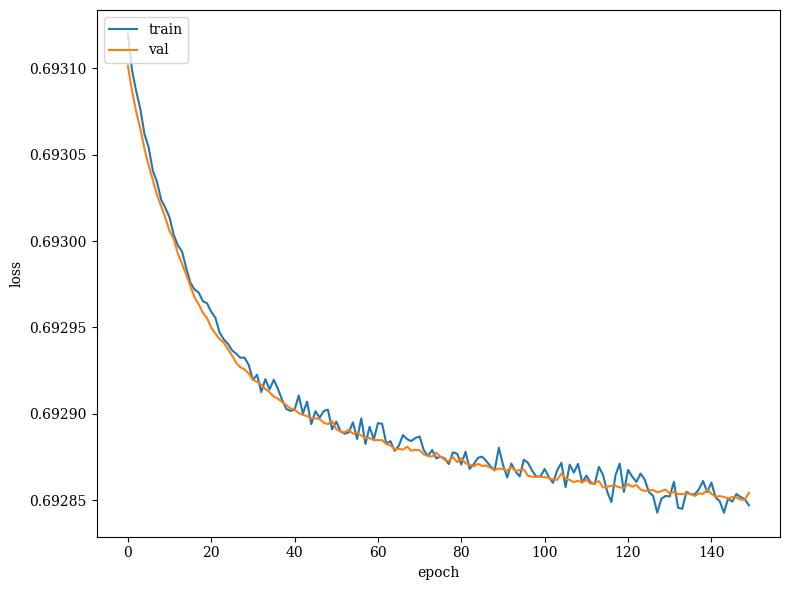

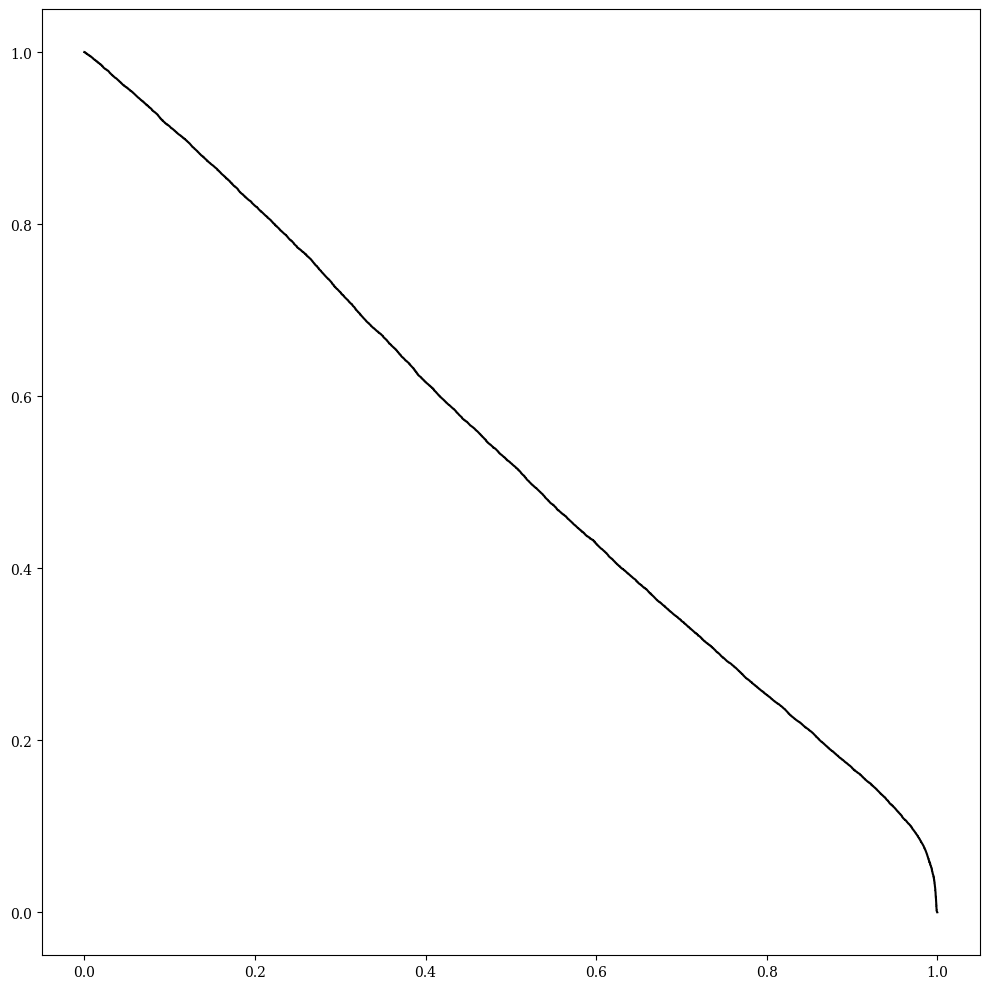

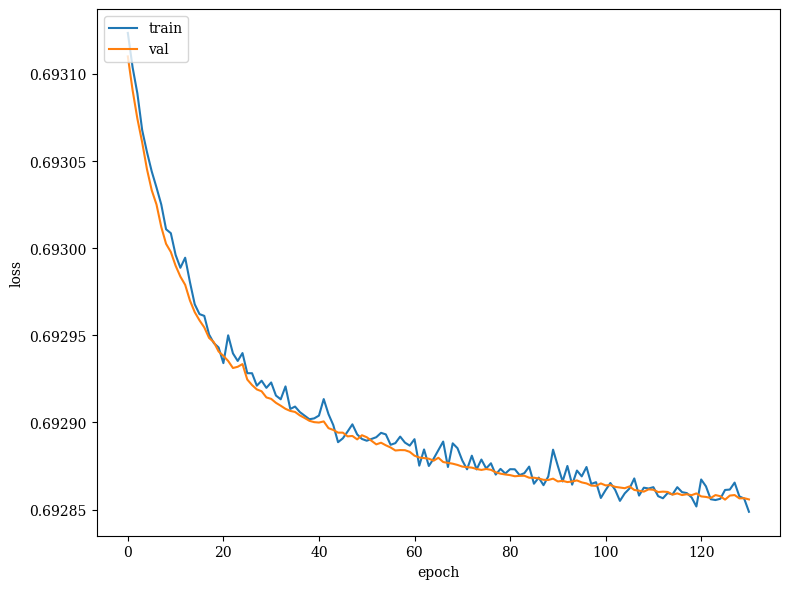

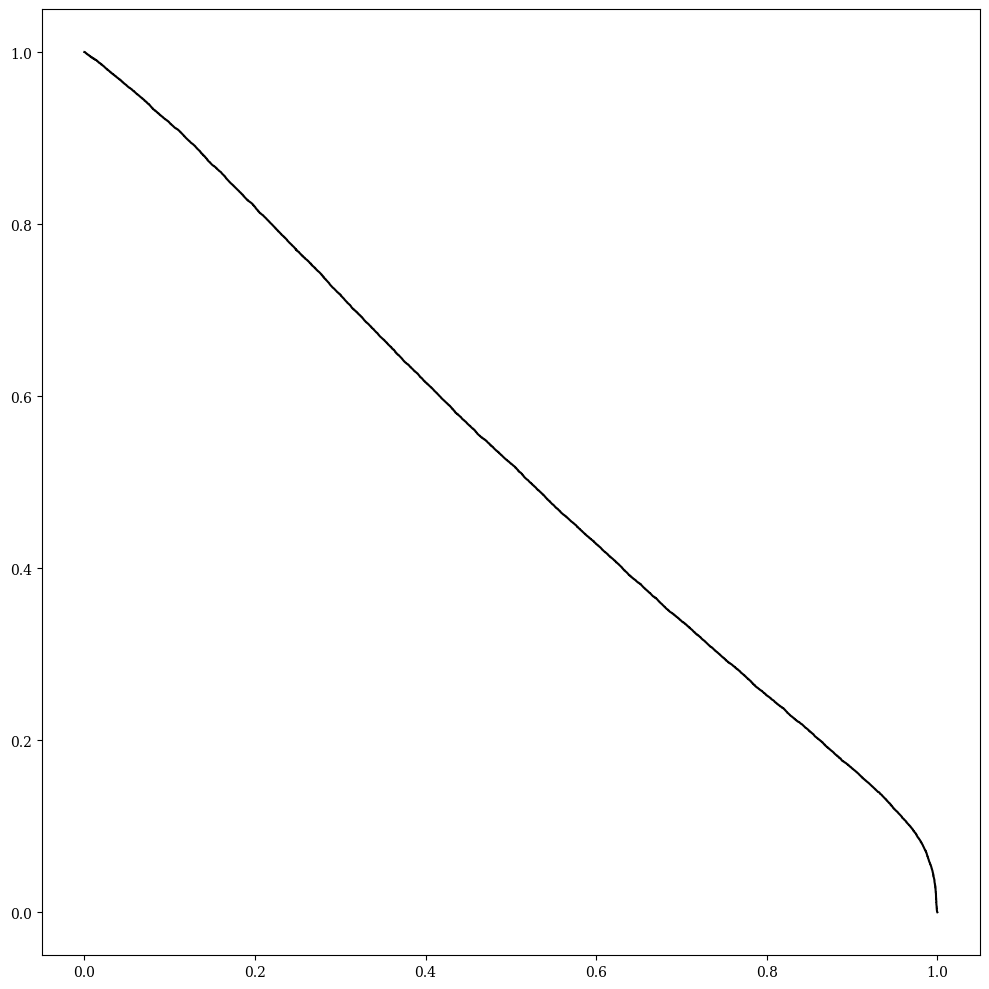

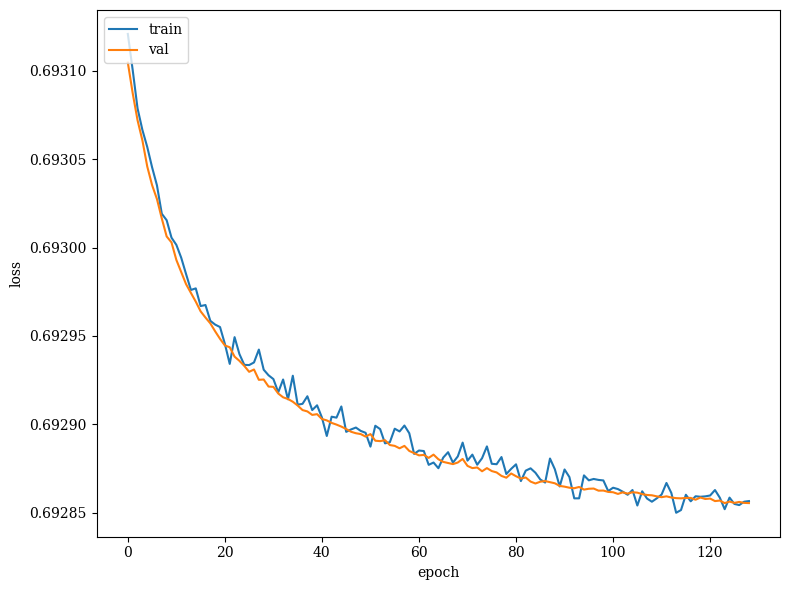

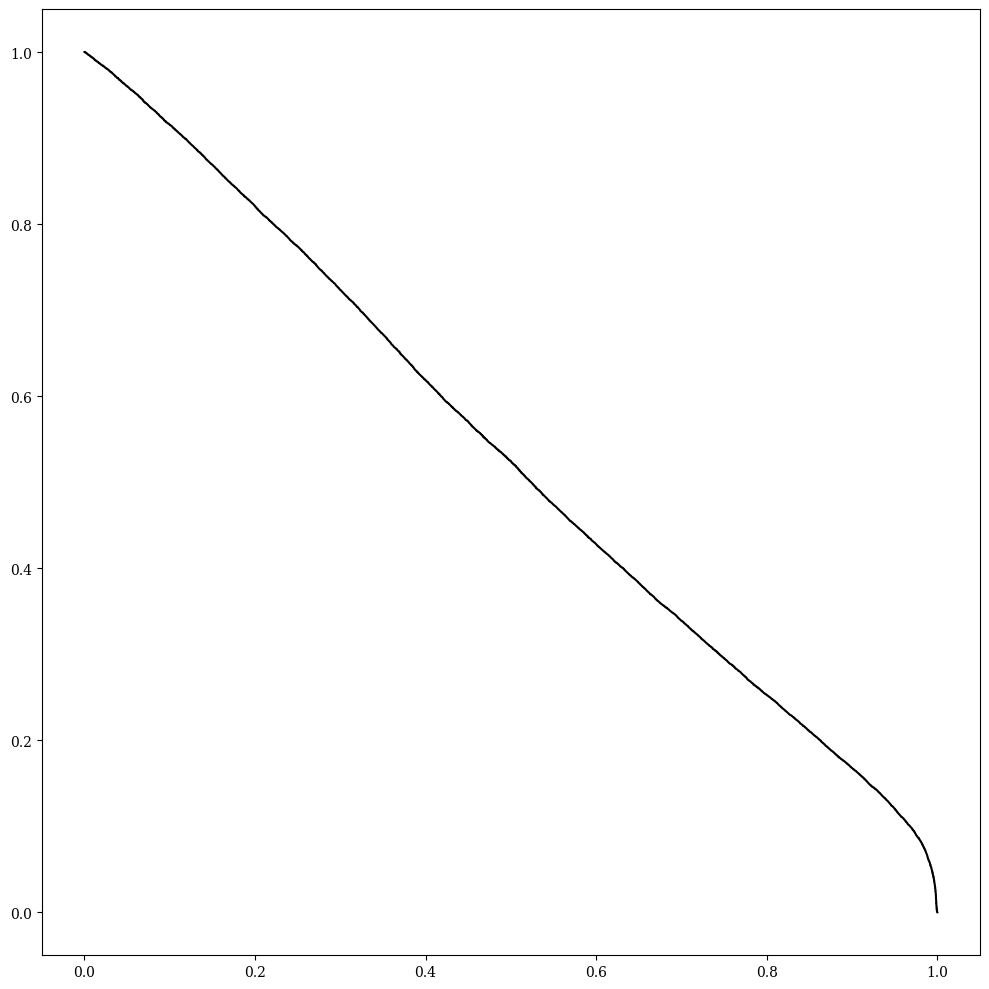

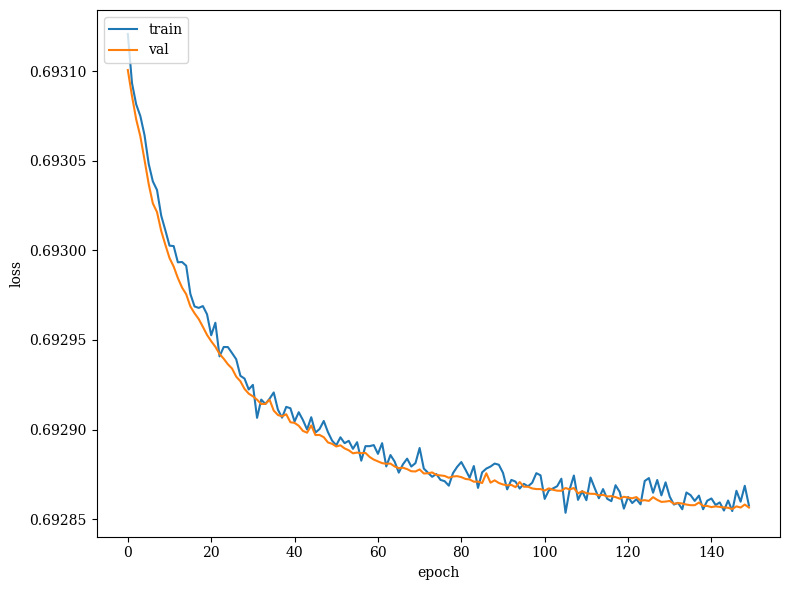

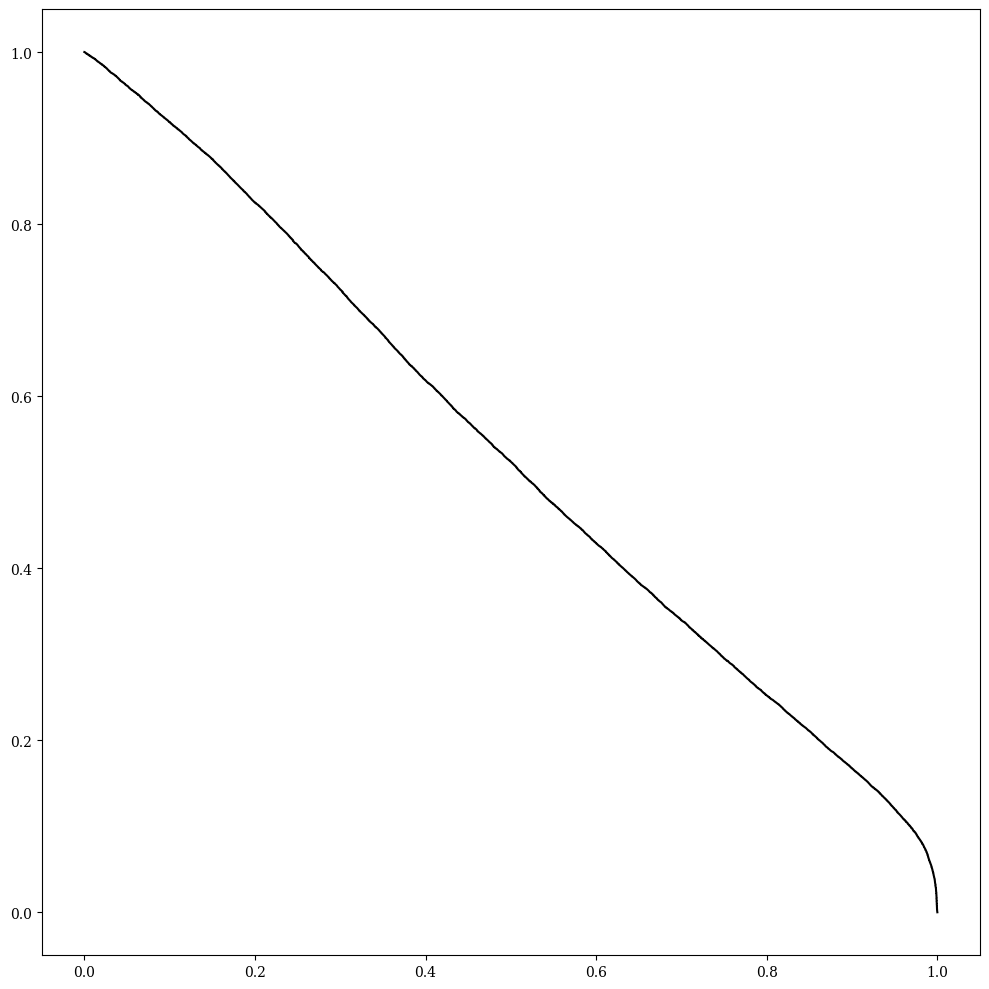

In [4]:
# EFN with spectral normalization
for i in range(6,11):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_v2/qjet_spectralEFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

# Gluon jets, R = 0.8

In [4]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('g',hlevel=True,efrac=False,base=base,nmax=nmax)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=False,base=base,nmax=nmax)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation_7 (Activation)      (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation_7[0][0]']           
                                                                                            

2381

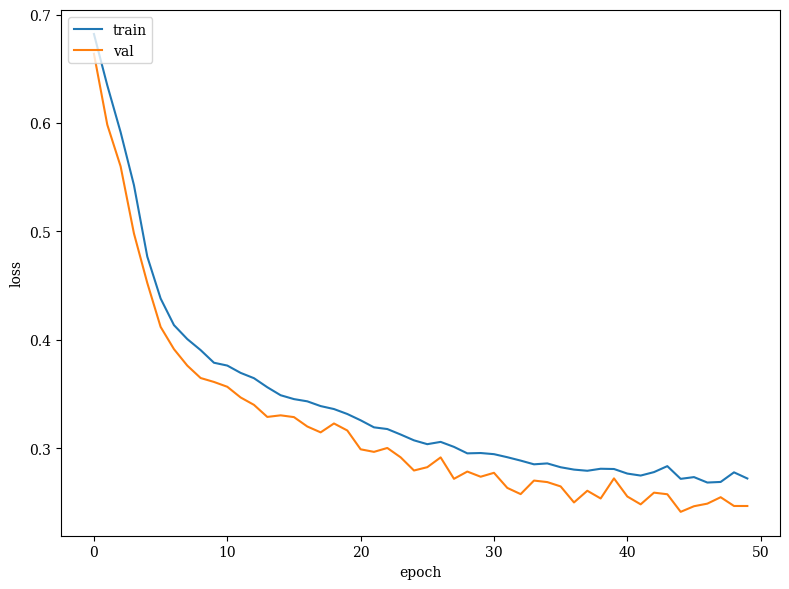

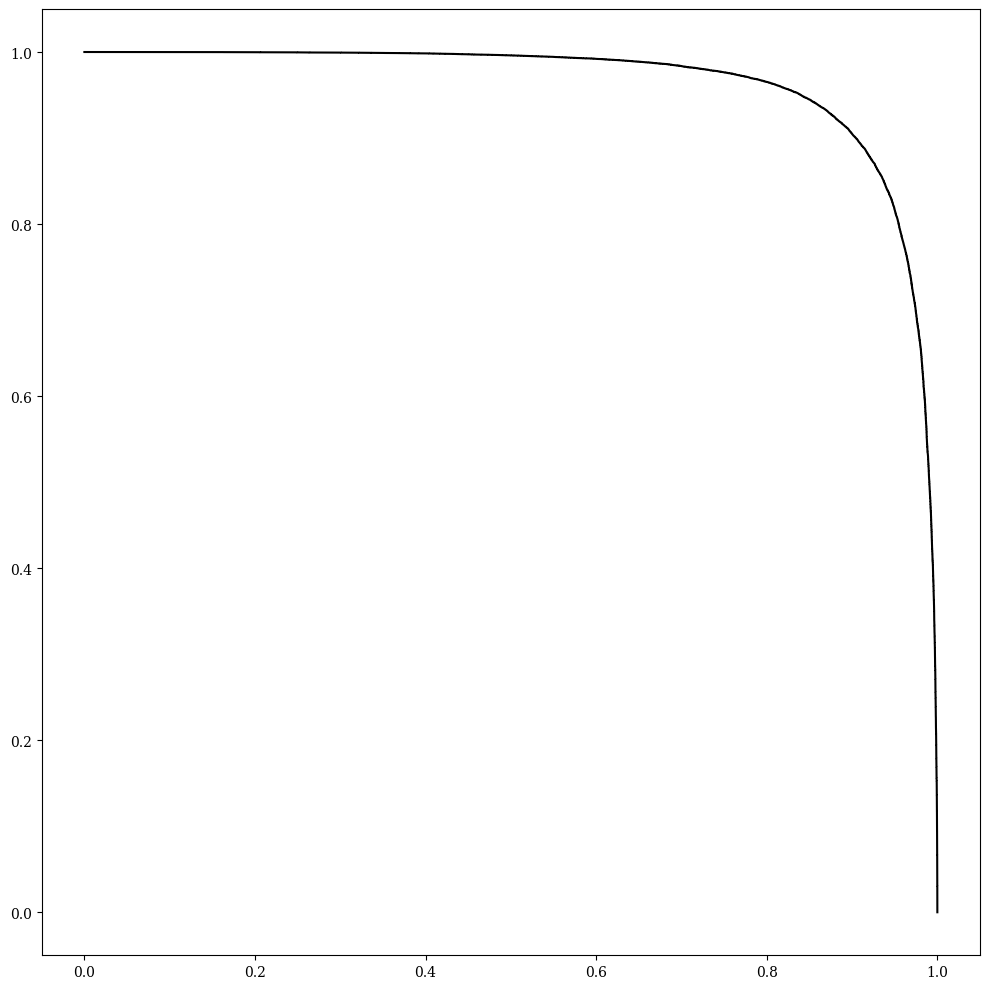

In [4]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":5,
                "optimizer":Adam(1e-3),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":100,"verbose":1,"batch_size":128}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn_name = "keras_models_v1/gjet_EFN_zpT_iter10.keras"
efn.save(efn_name)
del efn
gc.collect()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation_35 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_35[0][0]']          
                                                                                            

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 167ms/step - loss: 0.6931 - acc: 0.5082 - val_loss: 0.6931 - val_acc: 0.5161
Epoch 2/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6931 - acc: 0.5123 - val_loss: 0.6931 - val_acc: 0.5174
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5165 - val_loss: 0.6931 - val_acc: 0.5155
Epoch 4/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6931 - acc: 0.5138 - val_loss: 0.6930 - val_acc: 0.5136
Epoch 5/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6930 - acc: 0.5143 - val_loss: 0.6930 - val_acc: 0.5127
Epoch 6/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6930 - acc: 0.5132 - val_loss: 0.6930 - val_acc: 0.5131
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5114 - val_loss: 0.6930 - val_acc: 0.5126
Epoch 8/150
20/20 [==============================] - 3s 128ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 160ms/step - loss: 0.6931 - acc: 0.5122 - val_loss: 0.6931 - val_acc: 0.5136
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5114 - val_loss: 0.6931 - val_acc: 0.5131
Epoch 3/150
20/20 [==============================] - 3s 129ms/step - loss: 0.6931 - acc: 0.5125 - val_loss: 0.6931 - val_acc: 0.5113
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6931 - acc: 0.5096 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 5/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6931 - acc: 0.5107 - val_loss: 0.6930 - val_acc: 0.5117
Epoch 6/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6930 - acc: 0.5083 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 7/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6930 - acc: 0.5093 - val_loss: 0.6930 - val_acc: 0.5094
Epoch 8/150
20/20 [==============================] - 3s 129ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 156ms/step - loss: 0.6931 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5162
Epoch 2/150
20/20 [==============================] - 3s 129ms/step - loss: 0.6931 - acc: 0.5146 - val_loss: 0.6931 - val_acc: 0.5117
Epoch 3/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6931 - acc: 0.5119 - val_loss: 0.6931 - val_acc: 0.5119
Epoch 4/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6931 - acc: 0.5105 - val_loss: 0.6931 - val_acc: 0.5108
Epoch 5/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6931 - acc: 0.5092 - val_loss: 0.6930 - val_acc: 0.5115
Epoch 6/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5107 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 7/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6930 - acc: 0.5095 - val_loss: 0.6930 - val_acc: 0.5093
Epoch 8/150
20/20 [==============================] - 3s 130ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 161ms/step - loss: 0.6931 - acc: 0.5091 - val_loss: 0.6931 - val_acc: 0.5156
Epoch 2/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6931 - acc: 0.5138 - val_loss: 0.6931 - val_acc: 0.5150
Epoch 3/150
20/20 [==============================] - 3s 145ms/step - loss: 0.6931 - acc: 0.5137 - val_loss: 0.6931 - val_acc: 0.5122
Epoch 4/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5138 - val_loss: 0.6931 - val_acc: 0.5119
Epoch 5/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6931 - acc: 0.5100 - val_loss: 0.6931 - val_acc: 0.5102
Epoch 6/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6931 - acc: 0.5113 - val_loss: 0.6930 - val_acc: 0.5085
Epoch 7/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6930 - acc: 0.5096 - val_loss: 0.6930 - val_acc: 0.5101
Epoch 8/150
20/20 [==============================] - 3s 141ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 164ms/step - loss: 0.6931 - acc: 0.5116 - val_loss: 0.6931 - val_acc: 0.5132
Epoch 2/150
20/20 [==============================] - 3s 129ms/step - loss: 0.6931 - acc: 0.5112 - val_loss: 0.6931 - val_acc: 0.5119
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6931 - acc: 0.5104 - val_loss: 0.6931 - val_acc: 0.5086
Epoch 4/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6931 - acc: 0.5058 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 5/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6930 - acc: 0.5095 - val_loss: 0.6930 - val_acc: 0.5078
Epoch 6/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6930 - acc: 0.5074 - val_loss: 0.6930 - val_acc: 0.5083
Epoch 7/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6930 - acc: 0.5087 - val_loss: 0.6930 - val_acc: 0.5078
Epoch 8/150
20/20 [==============================] - 3s 139ms/step - 

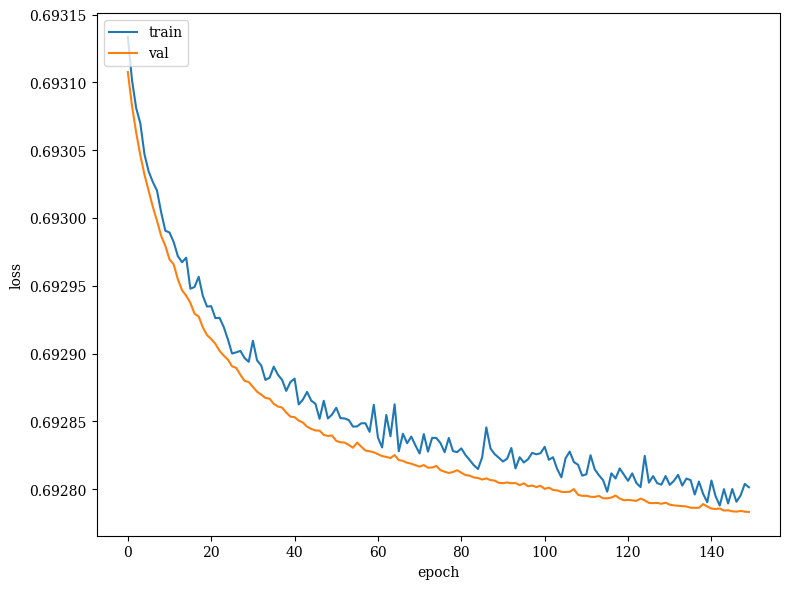

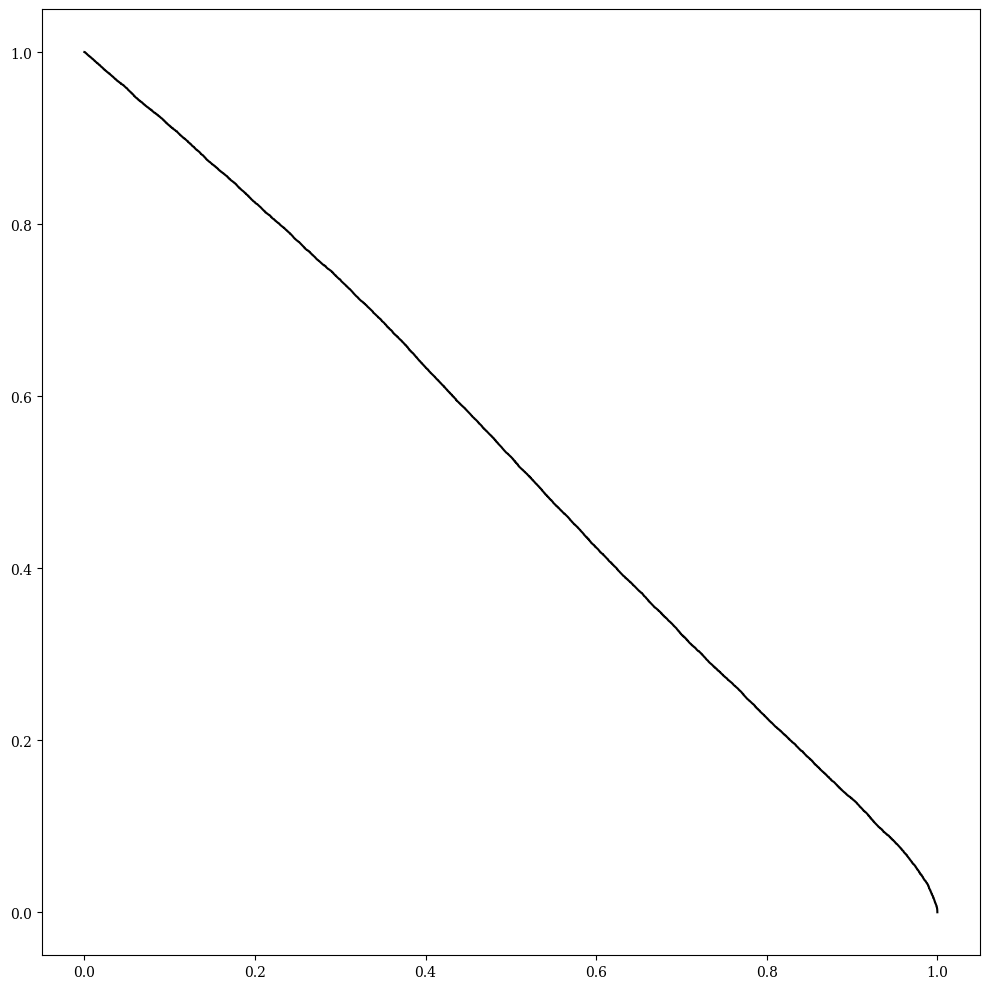

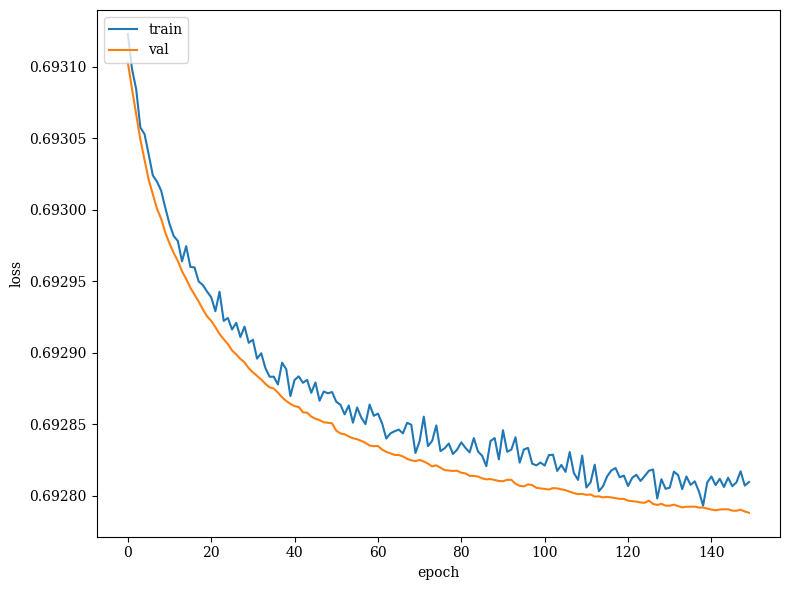

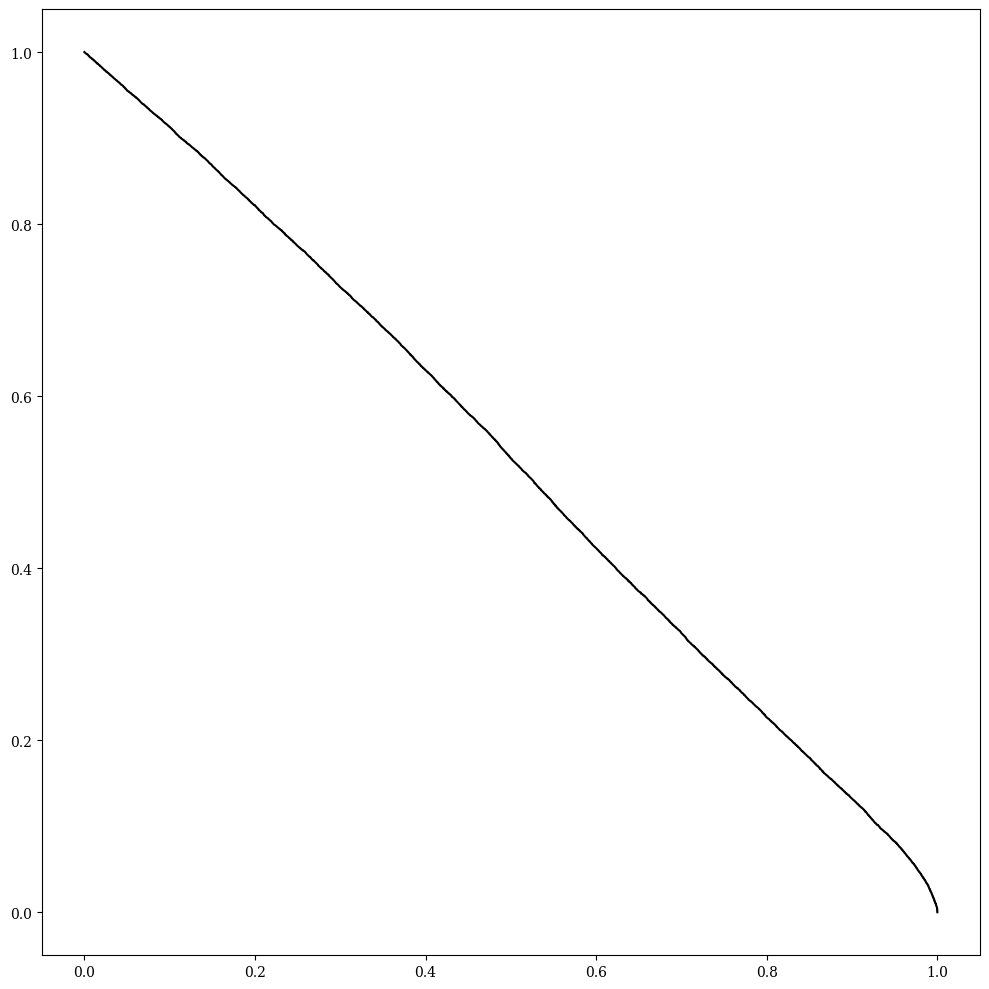

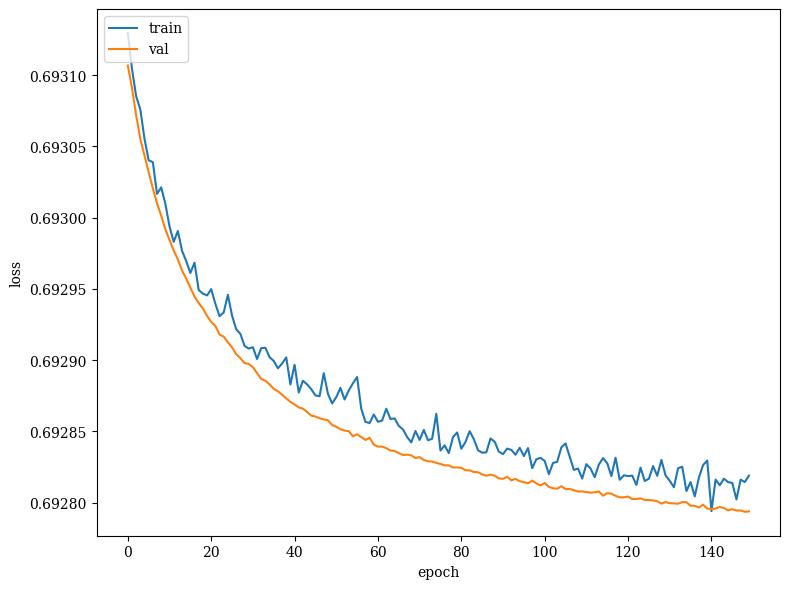

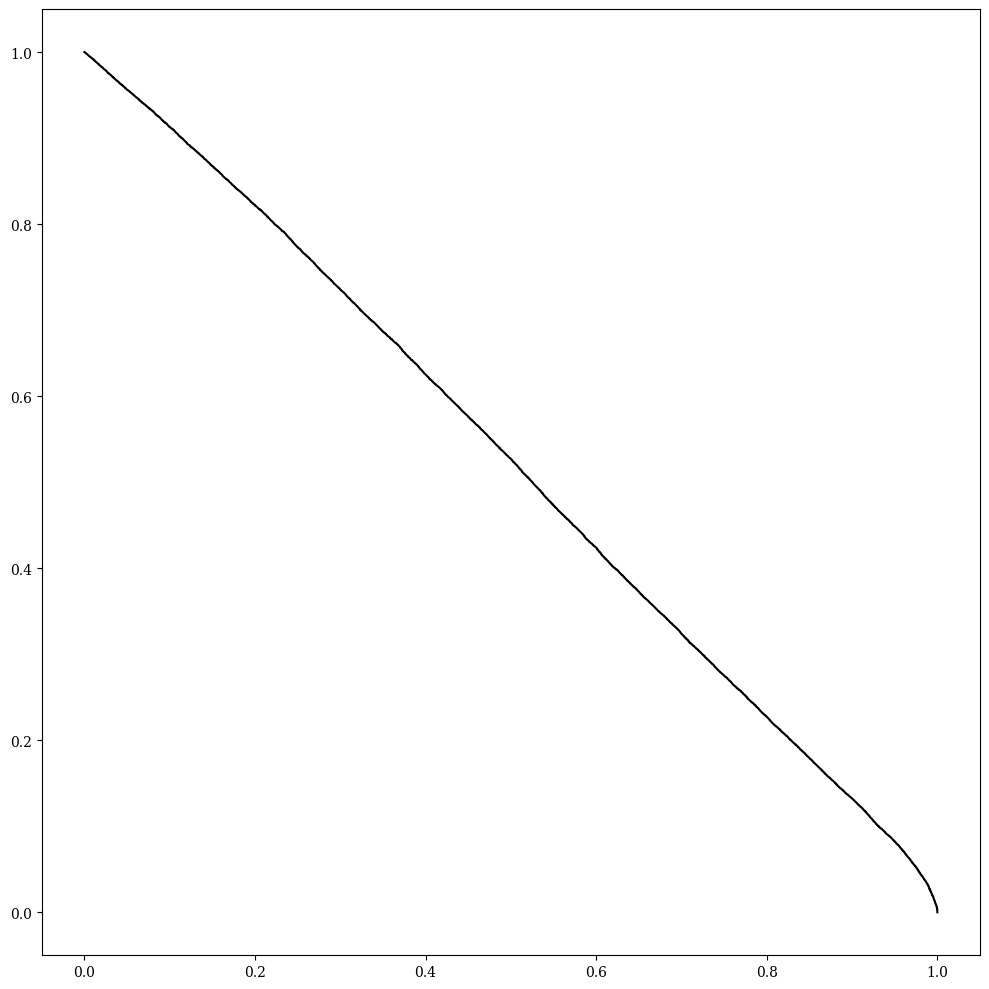

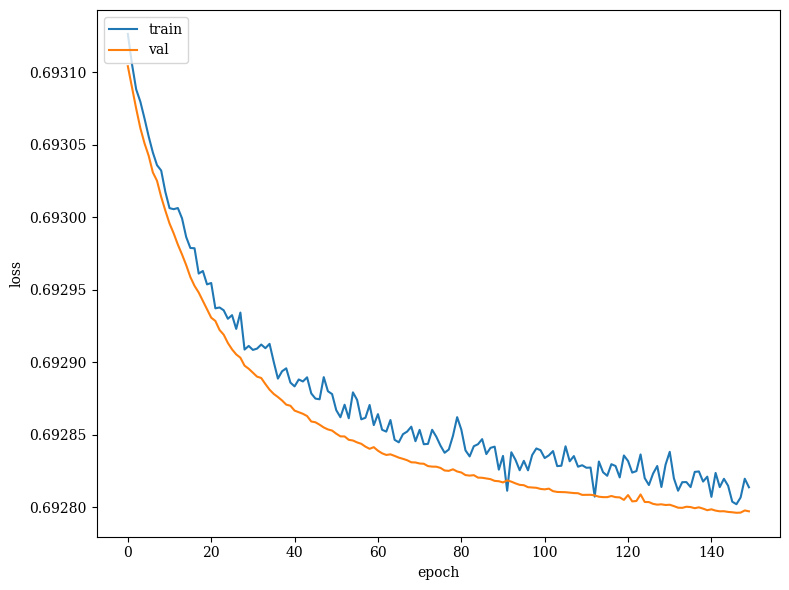

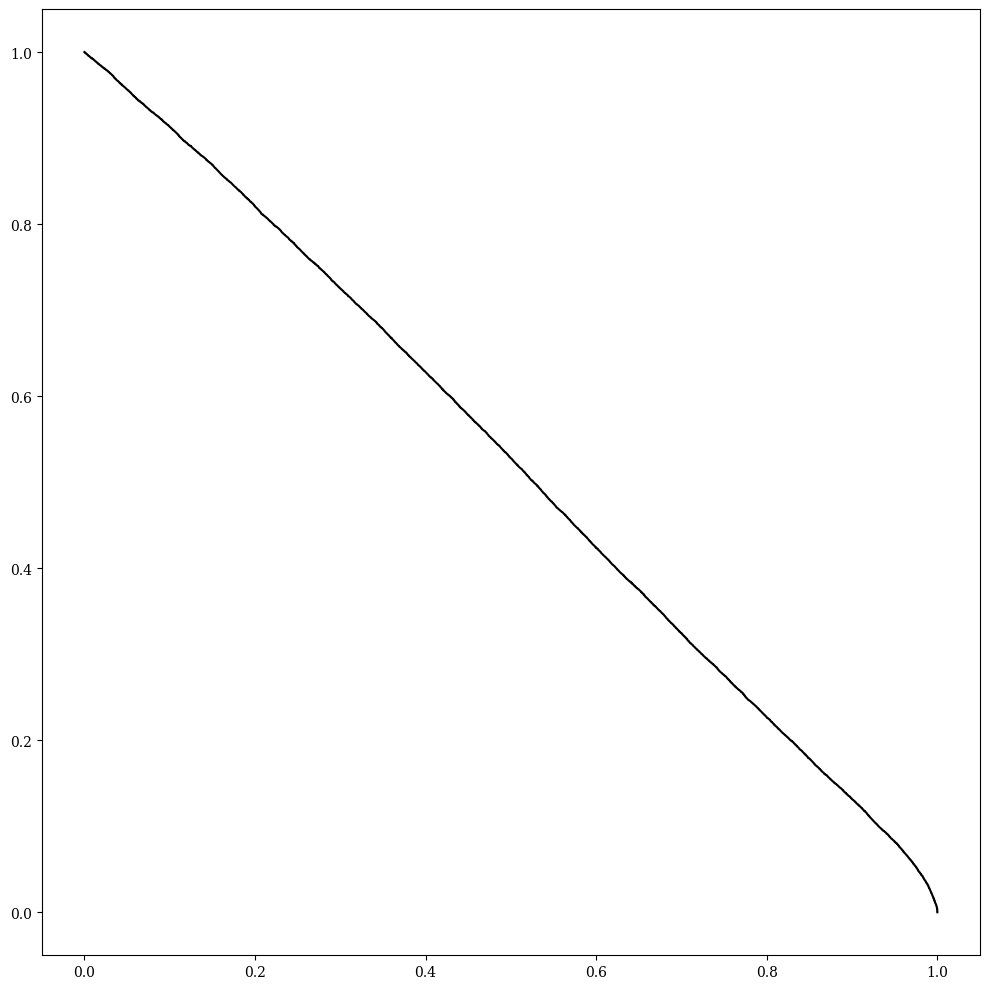

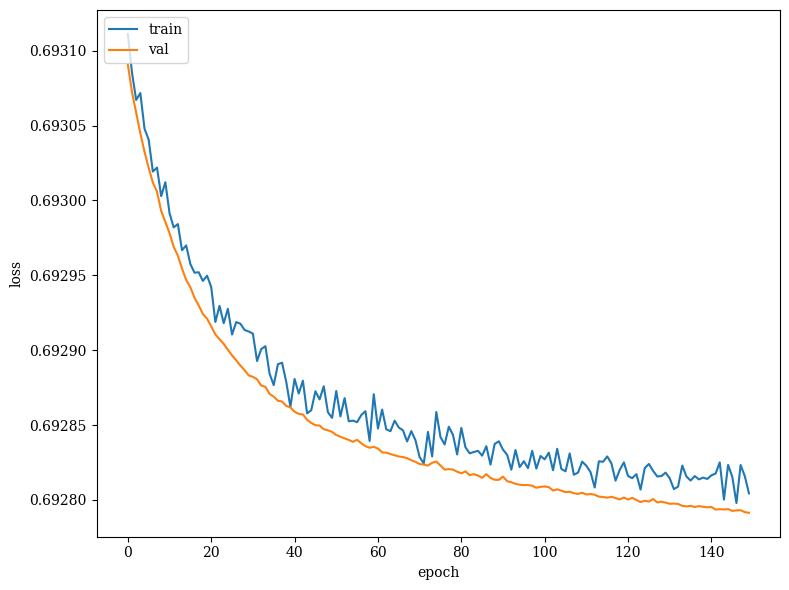

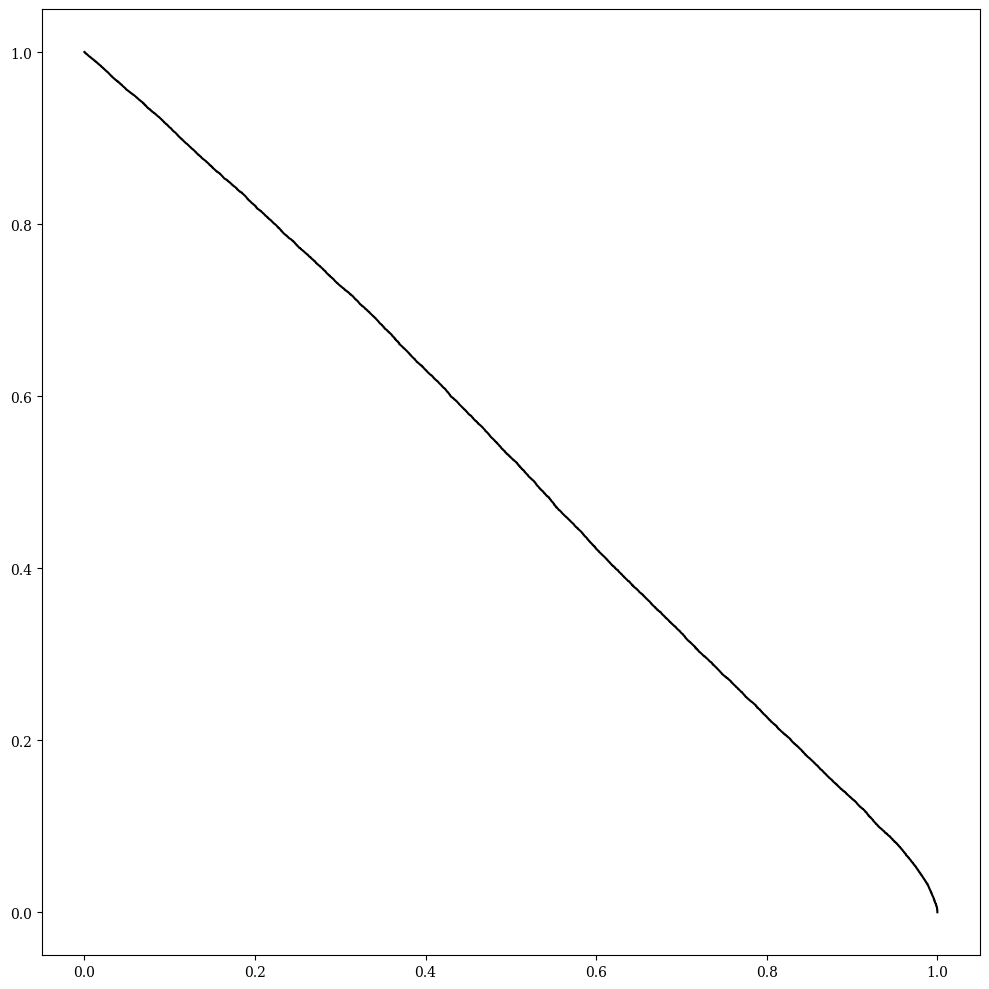

In [6]:
# EFN with spectral normalization
for i in range(6,11):
    loss = BinaryCrossentropy(from_logits=False)
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_v2/gjet_spectralEFN_zpT_iter{i}.keras")
    del efn
    gc.collect()